# 3. Beamforming for location

We now calculate the beamforming. This consists of calculating waveform features first (envelopes, kurtosis, etc.) and to shift-and-stack them according to the points in the 3D source-search grid previously calculated.

In [1]:
import beampower as bp
import glob
import numpy as np
import os
import pandas as pd
import tqdm
import xarray as xr

from matplotlib import pyplot as plt
from scipy import signal, stats
from obspy import read, read_inventory, UTCDateTime
from obspy.geodetics.base import locations2degrees, degrees2kilometers

beamnetresponse GPU library is not compiled! Build the GPU library first in order to use the GPU routines.


In [2]:
%load_ext autoreload
%autoreload 2

## Read travel times

Convert the travel times into int32 indexes.

In [3]:
travel_times = xr.load_dataarray("../data/travel_times.nc")

## Calculate waveform features

In [4]:
def envelope(x, dtype=np.float32):
    """Envelope function"""
    x = x.astype(dtype)

    # Normalize
    x_mad = stats.median_abs_deviation(x)
    x_mad = 1.0 if x_mad == 0.0 else x_mad

    # Envelope
    x = np.abs(signal.hilbert(x / x_mad))
    
    # Clip
    x_max = 10.0 ** (5.0 * stats.median_abs_deviation(x))
    return x.clip(None, x_max).astype(dtype)

In [5]:
DIRPATH_INVENTORY = "../data/processed/*.xml"
DIRPATH_WAVEFORMS = "../data/processed/*.mseed"
filepaths_waveforms = glob.glob(DIRPATH_WAVEFORMS)

# Header
header = read(filepaths_waveforms[0], headonly=True)[0]

waveform_features = xr.DataArray(
    dims=["station", "channel", "time"],
    coords={
        "channel": ["E", "N", "Z"],
        "station": travel_times.station.data,
        "time": pd.to_datetime(header.times("timestamp"), unit="s")
    }
)

for filepath in tqdm.tqdm(filepaths_waveforms, desc="Envelopes"):

    # Read trace
    trace = read(filepath)[0]

    # Assign
    info = trace.stats
    index = {"station": info.station, "channel": info.channel[-1]}
    waveform_features.loc[index] = envelope(trace.data)


Envelopes: 100%|██████████| 24/24 [00:06<00:00,  3.86it/s]


## Show an example envelope

Text(0.5, 1.0, '')

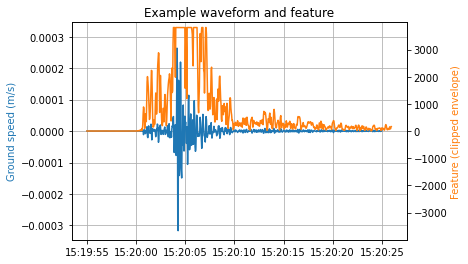

In [6]:
START, END = "2013-04-23 15:19:55", "2013-04-23 15:20:25"

# Get example waveform
stream = read(filepaths_waveforms[2])
stream.trim(starttime=UTCDateTime(START), endtime=UTCDateTime(END))

# Trace
trace = stream[0]
times = pd.to_datetime(trace.times("timestamp"), unit="s")

# Plot
fig, ax = plt.subplots()
ax.plot(times, trace.data)
ymax = max(np.abs(ax.get_ylim()))
ax.set_ylim(-ymax, ymax)
ax.set_ylabel("Ground speed (m/s)", color="C0")
ax.set_title("Example waveform and feature")
ax.grid()

# Envelope on a second axe (not the same scale)
feature = waveform_features.sel(
    station=trace.stats.station,
    channel=trace.stats.channel[-1],
    time=slice(START, END),
)
ax = ax.twinx()
feature.plot(ax=ax, color="C1")
ax.set_ylabel("Feature (clipped envelope)", color="C1")
ax.set_ylim(bottom=-max(ax.get_ylim()))
ax.set_title("")


## Source and phase weights

In [7]:
sampling_rate = header.stats.sampling_rate

# Get time delays
time_delays = np.round(sampling_rate * travel_times)
time_delays = time_delays.stack(source=["latitude", "longitude", "depth"])
time_delays = time_delays.transpose("source", "station", "phase").to_numpy()
time_delays = time_delays.astype(np.int32)

# Phase weights
weights_phase = xr.ones_like(waveform_features.isel(time=0).drop("time"))
weights_phase = weights_phase.expand_dims({"phase": 2})
weights_phase = weights_phase.assign_coords({"phase": list("PS")})
weights_phase = weights_phase.copy()
weights_phase.loc[{"channel": ["E", "N"], "phase": "P"}] = 0.0
weights_phase.loc[{"channel": "Z", "phase": "S"}] = 0.0
weights_phase = weights_phase.transpose(
    "station", "channel", "phase"
).to_numpy().astype(np.float32)

# Sources weights
weights_sources = np.ones(time_delays.shape[:-1], dtype=np.float32)

 
features = waveform_features.to_numpy().astype(np.float32)

In [8]:
# Beamform
response, source_id = bp.beampower.beamform_max(
    features,
    time_delays,
    weights_phase,
    weights_sources,
    device="cpu"
)

: 

: 

## Detect

In [ ]:
# Get arrays
beam = xr.DataArray(data=response, coords=waveform_features["time"].coords)

# Threshold
window_length = int(1800 * sampling_rate)
threshold = 3 * beam.rolling(time=window_length, center=True).median()

# Dataset
detector = xr.Dataset({"beam": beam, "threshold": threshold})

# Source index
dims = ["latitude", "longitude", "depth"]
detector = detector.assign({"source_index": ("time", source_id)})
vectors = [travel_times[dim] for dim in dims]
grid = [dim.ravel()[source_id] for dim in np.meshgrid(*vectors, indexing="ij")]
grid = {dim: ("time", grid[index]) for index, dim in enumerate(dims)}
detector = detector.assign(grid)

In [ ]:
MIN_DETECTION_INTERVAL = int(30 * sampling_rate)
# Detection
peaks = signal.find_peaks(detector.beam, distance=MIN_DETECTION_INTERVAL)
events = detector.isel(time=peaks[0])
events = events.isel(time=events.beam > events.threshold)

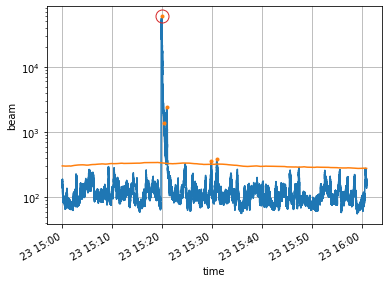

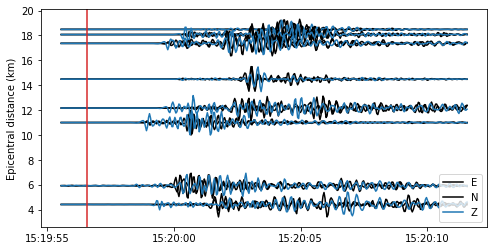

In [ ]:
COLORS = {"E": "k", "N": "k", "Z": "C0"}

select = slice("2013-04-23 15:00", "2013-04-23 16:00")
inventory = read_inventory(DIRPATH_INVENTORY)
detector_zoom = detector.sel(time=select)
events_zoom = events.sel(time=select)

# Show
detector_zoom.beam.plot()
detector_zoom.threshold.plot()
events_zoom.beam.plot(marker=".", ls="none", c="C1")
plt.semilogy()
plt.grid()

# Watch peak
event_watch = events_zoom.isel(time=events_zoom.beam.argmax())
# event_watch = events.isel(time=4)
plt.plot(event_watch.time, event_watch.beam, "oC3", ms=13, mfc="none")

# str(event_watch.time.data)
date = UTCDateTime(str(event_watch.time.data))

# Get waveform
fig, ax = plt.subplots(1, figsize=(8, 4))
for index, trace in enumerate(read(DIRPATH_WAVEFORMS)):

    # Get trace and info
    trace.trim(date - 1, date + 15)        
    trace.filter(type="lowpass", freq=5)
    times = pd.to_datetime(trace.times("timestamp"), unit="s")
    data = trace.data / np.abs(trace.data).max()
    coords = inventory.get_coordinates(trace.id)
    p1 = event_watch.latitude.data, event_watch.longitude.data
    p2 = [coords[dim] for dim in ["latitude", "longitude"]]
    distance = degrees2kilometers(locations2degrees(*p1, *p2))

    # Plot trace
    ax.plot(times, data + distance, color=COLORS[trace.stats.channel[-1]])
    
# 
ax.set_ylabel("Epicentral distance (km)")
ax.axvline(date, color="C3")
ax.legend([key for key in COLORS])
    

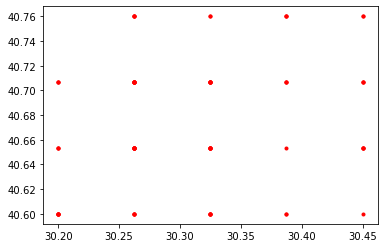

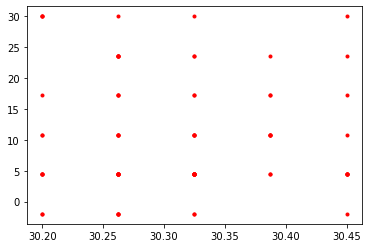

In [ ]:
plt.plot(events.longitude, events.latitude, ".r")
plt.figure()
plt.plot(events.longitude, events.depth, ".r")